In [ ]:
%matplotlib inline

import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def read_and_split(filename, train_X, train_Y, validation_X, validation_Y, test_X, test_Y, label, n=5332):
    
    with open(str(dataset_path / filename), 'rt') as f:
        
        for _ in range(int(0.6*n)):
            train_X.append(f.readline())
            train_Y.append(label)
            
        for _ in range(int(0.6*n), int(0.8*n)):
            validation_X.append(f.readline())
            validation_Y.append(label)
            
        for _ in range(int(0.8*n), n):
            test_X.append(f.readline())
            test_Y.append(label)

In [ ]:
def get_model(variant, batch_size, hidden_neurons, SEQ_LEN, learning_rate):
    
    train_padded = pad_sequences(train_seq, padding='post', maxlen=SEQ_LEN)
    validation_padded = pad_sequences(validation_seq, padding='post', maxlen=SEQ_LEN)
    test_padded = pad_sequences(test_seq, padding='post', maxlen=SEQ_LEN)
            
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=300, 
                        embeddings_initializer=Constant(embedding_matrix), mask_zero=True, 
                        input_length=SEQ_LEN, trainable=False))
    
    if variant == 'vanilla_rnn':
        model.add(SimpleRNN(units=hidden_neurons))
    elif variant == 'lstm':
        model.add(LSTM(units=hidden_neurons))
    else:
        model.add(GRU(units=hidden_neurons))
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    print(model.summary())
    
    stopping_criteria = EarlyStopping(min_delta=0.001, patience=2, verbose=1)
    
    history = model.fit(x=train_padded, y=train_Y, batch_size=batch_size, epochs=15,
                        verbose=2, callbacks=(stopping_criteria), validation_data=(validation_padded, validation_Y))
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    return model, test_padded

In [ ]:
def run_on_test(variant, model, test_padded):
    
    print(f'Result on the test set for RNN variant - {variant}:')
    model.evaluate(x=test_padded, y=test_Y)
    test_pred = (model.predict(test_padded) > 0.5).astype(dtype=np.int8)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true=test_Y, y_pred=test_pred, average='binary')
    print(f'Precision: {precision} \nRecall: {recall} \nF1-Score: {fscore}')

In [ ]:
cur_dir = Path.cwd()
dataset_path = cur_dir / 'Dataset' / 'rt-polaritydata'
embeddings_path = cur_dir / 'word_representations' / 'glove.6B' / 'glove.6B.300d.txt'
        
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = [], [], [], [], [], []
            
read_and_split('rt-polarity.pos', train_X, train_Y, validation_X, validation_Y, test_X, test_Y, label=1)
read_and_split('rt-polarity.neg', train_X, train_Y, validation_X, validation_Y, test_X, test_Y, label=0)

train_Y = np.asarray(train_Y, dtype=np.int8).reshape((-1, 1))
validation_Y = np.asarray(validation_Y, dtype=np.int8).reshape((-1, 1))
test_Y = np.asarray(test_Y, dtype=np.int8).reshape((-1, 1))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_seq = tokenizer.texts_to_sequences(train_X)
validation_seq = tokenizer.texts_to_sequences(validation_X)
test_seq = tokenizer.texts_to_sequences(test_X)

embeddings_index = {}
with open(str(embeddings_path), 'rt', encoding='utf-8') as f:
    for line in f.readlines():
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs       
        
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index, :] = embedding_vector

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_77 (Embedding)     (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn_75 (SimpleRNN)    (None, 100)               40100     
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 101       
Total params: 4,564,501
Trainable params: 40,201
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 4s - loss: 0.7156 - accuracy: 0.5258 - val_loss: 0.7003 - val_accuracy: 0.5403
Epoch 2/15
64/64 - 3s - loss: 0.6775 - accuracy: 0.5788 - val_loss: 0.6823 - val_accuracy: 0.5694
Epoch 3/15
64/64 - 3s - loss: 0.6497 - accuracy: 0.6207 - val_loss: 0.6644 - val_accuracy: 0.5938
Epoch 4/15
64/64 - 3s - loss: 0.6135 - accuracy: 0.6655 - val_loss: 0

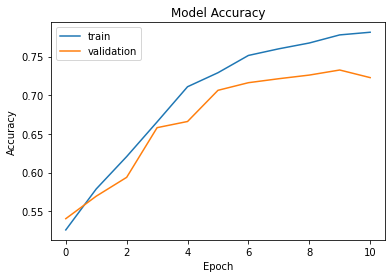

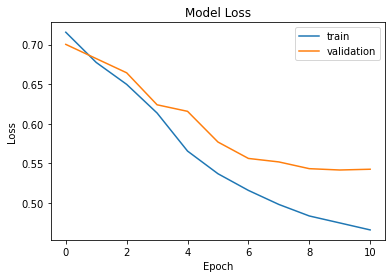

In [110]:
model_RNN, test_padded_RNN = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=100, SEQ_LEN=51, learning_rate=0.001)

In [ ]:
model_2, test_padded_2 = get_model(variant='vanilla_rnn', batch_size=10, hidden_neurons=100, SEQ_LEN=51, learning_rate=0.0001)

In [ ]:
model_3, test_padded_3 = get_model(variant='vanilla_rnn', batch_size=250, hidden_neurons=100, SEQ_LEN=51, learning_rate=0.0001)

In [ ]:
model_4, test_padded_4 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=10, SEQ_LEN=51, learning_rate=0.0001)

In [ ]:
model_5, test_padded_5 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=250, SEQ_LEN=51, learning_rate=0.0001)

In [ ]:
model_6, test_padded_6 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=100, SEQ_LEN=25, learning_rate=0.0001)

In [ ]:
model_7, test_padded_7 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=100, SEQ_LEN=100, learning_rate=0.0001)

In [ ]:
model_8, test_padded_8 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=100, SEQ_LEN=51, learning_rate=0.001)

In [ ]:
model_9, test_padded_9 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=100, SEQ_LEN=51, learning_rate=0.00001)

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_84 (Embedding)     (None, 51, 300)           4524300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 101       
Total params: 4,684,801
Trainable params: 160,501
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 11s - loss: 0.5898 - accuracy: 0.6783 - val_loss: 0.5258 - val_accuracy: 0.7294
Epoch 2/15
64/64 - 10s - loss: 0.4811 - accuracy: 0.7723 - val_loss: 0.4948 - val_accuracy: 0.7477
Epoch 3/15
64/64 - 10s - loss: 0.4433 - accuracy: 0.7895 - val_loss: 0.4864 - val_accuracy: 0.7570
Epoch 4/15
64/64 - 10s - loss: 0.4094 - accuracy: 0.8101 - val_lo

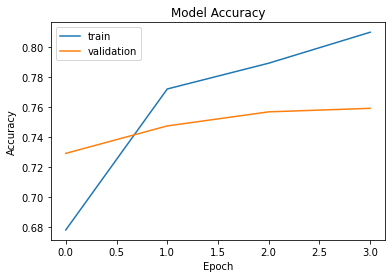

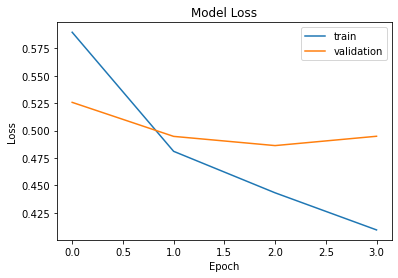

In [117]:
model_RNN, test_padded_RNN = get_model(variant='lstm', batch_size=100, hidden_neurons=100, SEQ_LEN=51, learning_rate=0.001)

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_85 (Embedding)     (None, 51, 300)           4524300   
_________________________________________________________________
gru_6 (GRU)                  (None, 100)               120600    
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 101       
Total params: 4,645,001
Trainable params: 120,701
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 10s - loss: 0.6172 - accuracy: 0.6513 - val_loss: 0.5312 - val_accuracy: 0.7322
Epoch 2/15
64/64 - 9s - loss: 0.4971 - accuracy: 0.7566 - val_loss: 0.5062 - val_accuracy: 0.7430
Epoch 3/15
64/64 - 9s - loss: 0.4530 - accuracy: 0.7832 - val_loss: 0.4800 - val_accuracy: 0.7523
Epoch 4/15
64/64 - 9s - loss: 0.4186 - accuracy: 0.8056 - val_loss:

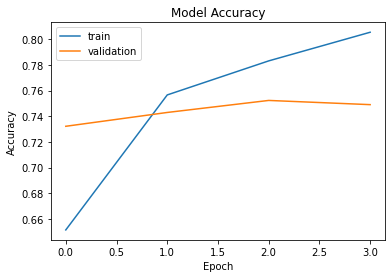

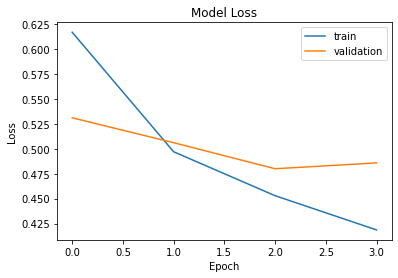

In [118]:
model_RNN, test_padded_RNN = get_model(variant='gru', batch_size=100, hidden_neurons=100, SEQ_LEN=51, learning_rate=0.001)